In this section, We will import the necessary libraries for creating dataframes and for grouping neighborhoods by those postal codes.

In [19]:
# Import / install required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import re
import requests
from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [21]:
df = pd.read_csv('BangaloreCoordinates.csv')
df.head()

,Postcode,Neighborhood,Borough,longitude,latitude
0,560045,Arabic College S.O,Bangalore North,77.6206,13.0291
1,560103,Bellandur S.O,Bangalore South,77.6760,12.9298
2,560071,Domlur S.O,Bangalore North,77.6359,12.9611
3,560077,Dr. Shivarama Karanth Nagar S.O,Bangalore North,77.6293,13.0681
4,560005,Fraser Town S.O,Bangalore North,77.6164,13.0005


In [22]:
# Store Foursquare credentials and parameters.
CLIENT_ID = 'M4DGAVRZVY0YMEPXAS1IOQRP4OMJGXMIKZA3WFF31O4KWRDI' # Confidential.
CLIENT_SECRET = 'CGCL32Z3FS4BIAYTTFYQ2JYAK5VKEPHOCY5AKMTJHO3OZ0W0' # Confidential.
VERSION = '20180605' 
LIMIT = 100
radius = 500

In [23]:
# Retrieve venue data from Foursquare.
venues_list=[]
for name, lat, lng in zip(df['Neighborhood'], 
                          df['latitude'], 
                          df['longitude']):

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

bangalore_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
bangalore_venues.columns = ['Neighborhood', 
                         'Neighborhood Latitude', 
                         'Neighborhood Longitude', 
                         'Venue', 
                         'Venue Latitude', 
                         'Venue Longitude', 
                         'Venue Category']

bangalore_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arabic College S.O,13.0291,77.6206,Dezyon Interiors,13.029936,77.624120,Furniture / Home Store
1,Arabic College S.O,13.0291,77.6206,New Krishna Sagar,13.026125,77.622722,Indian Restaurant
2,Arabic College S.O,13.0291,77.6206,Mateen Marketing,13.033118,77.619645,Furniture / Home Store
3,Bellandur S.O,12.9298,77.6760,Kicks On Grass,12.930045,77.679679,Soccer Field
4,Bellandur S.O,12.9298,77.6760,KFC,12.925980,77.675349,Fast Food Restaurant


In [24]:
# Print number of unique catagories.
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 176 uniques categories.


In [25]:
# Print top 120 most common venue types.
bangalore_venues['Venue Category'].value_counts().head(10)

Indian Restaurant       201
Café                     80
Fast Food Restaurant     44
Chinese Restaurant       36
Ice Cream Shop           34
Bakery                   32
Pizza Place              30
Hotel                    24
Coffee Shop              23
Restaurant               23
Name: Venue Category, dtype: int64

In [26]:
# Create table of venues per neighborhood.
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
bangalore_onehot.shape

(1107, 176)

In [28]:
bangalore_grouped = bangalore_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Art Museum,Arts & Crafts Store,...,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel & Transport,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Women's Store
0,Arabic College S.O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ashoknagar S.O (Bangalore),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B Sk II Stage S.O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bangalore G.P.O.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bannerghatta Road S.O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
bangalore_grouped.shape

(108, 176)

In [30]:
# Create table of most common venues per neighborhood.
# Define function.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arabic College S.O,Furniture / Home Store,Indian Restaurant,Women's Store,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
1,Ashoknagar S.O (Bangalore),Indian Restaurant,Indie Movie Theater,Breakfast Spot,Juice Bar,Szechuan Restaurant,Park,Eastern European Restaurant,Flea Market,Fish Market,Financial or Legal Service
2,B Sk II Stage S.O,Ice Cream Shop,Mediterranean Restaurant,Pizza Place,Fast Food Restaurant,Women's Store,Flea Market,Fish Market,Financial or Legal Service,Farmers Market,Electronics Store
3,Bangalore G.P.O.,Indian Restaurant,Café,Hotel,Intersection,Asian Restaurant,Capitol Building,Park,Chinese Restaurant,Discount Store,Dog Run
4,Bannerghatta Road S.O,Café,Indian Restaurant,Office,Sandwich Place,Food Court,Hotel,Hospital,Fast Food Restaurant,Hotel Bar,Farmers Market


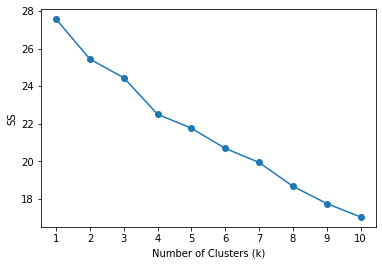

In [31]:
# Conduct Elbow Sum-of-Squares test on clustering DataFrame.
bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

k_range = range(1,11)
sum_of_squares = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(bangalore_grouped_clustering)
    sum_of_squares.append(KM.inertia_)
    
plt.plot(k_range, sum_of_squares, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [32]:
# Conduct silhouette test on clustering DataFrame.
from sklearn.metrics import silhouette_samples, silhouette_score

best=0

for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(bangalore_grouped_clustering)
    silhouette_avg = silhouette_score(bangalore_grouped_clustering, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.09754727623279817
For n_clusters = 3 The average silhouette_score is : 0.11956569533488241
For n_clusters = 4 The average silhouette_score is : 0.05114096057529622
For n_clusters = 5 The average silhouette_score is : 0.1108033038207263
For n_clusters = 6 The average silhouette_score is : 0.07992992528633572
For n_clusters = 7 The average silhouette_score is : 0.06750253748467257
For n_clusters = 8 The average silhouette_score is : 0.07658906938007337
For n_clusters = 9 The average silhouette_score is : 0.07735708225401026
For n_clusters = 10 The average silhouette_score is : 0.07251426549625564
Optimal KMeans n_clusters parameter: 3


In [33]:
# run k-means clustering.
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# Print count of neighborhoods per cluster.
pd.Series(kmeans.labels_).value_counts()

1    54
0    40
2     9
3     5
dtype: int64

In [34]:
# add clustering labels.
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
bangalore_merged = df.drop('Postcode', axis=1)

# merge bangalore_grouped with bangalore_data to add latitude/longitude for each neighborhood.
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
bangalore_merged.head()

,Neighborhood,Borough,longitude,latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arabic College S.O,Bangalore North,77.6206,13.0291,0.0,Furniture / Home Store,Indian Restaurant,Women's Store,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
1,Bellandur S.O,Bangalore South,77.6760,12.9298,1.0,Fast Food Restaurant,Indian Restaurant,Food Court,Pizza Place,Kerala Restaurant,Athletics & Sports,Moving Target,Multiplex,Shopping Mall,Café
2,Domlur S.O,Bangalore North,77.6359,12.9611,0.0,Café,Indian Restaurant,Pizza Place,Women's Store,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
3,Dr. Shivarama Karanth Nagar S.O,Bangalore North,77.6293,13.0681,1.0,Punjabi Restaurant,Kids Store,Asian Restaurant,Dumpling Restaurant,Women's Store,Donut Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
4,Fraser Town S.O,Bangalore North,77.6164,13.0005,0.0,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Ice Cream Shop,Bakery,Chinese Restaurant,Department Store,South Indian Restaurant,Movie Theater,Flea Market


In [35]:
!pip install geopy
# Import Nominatim.
from geopy.geocoders import Nominatim

# Retrieve coordinates for Toronto.
address = 'Bangalore, IN'
geolocator = Nominatim(user_agent="blore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [36]:
# Create mpa visual with clustered neighborhoods.
# Create folium map.
zoom = 12
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=zoom, min_zoom=zoom, max_zoom=zoom)

# Set color scheme for the clusters.
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow((np.linspace(0, 1, len(ys))))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [37]:
# add markers to the map.
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['latitude'], bangalore_merged['longitude'], bangalore_merged['Neighborhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float

In [38]:
df_cluster_0 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]
df_cluster_0.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangalore North,Furniture / Home Store,Indian Restaurant,Women's Store,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
2,Bangalore North,Café,Indian Restaurant,Pizza Place,Women's Store,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
4,Bangalore North,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Ice Cream Shop,Bakery,Chinese Restaurant,Department Store,South Indian Restaurant,Movie Theater,Flea Market
8,Bangalore North,Indian Restaurant,Dessert Shop,Chinese Restaurant,Food Truck,Karnataka Restaurant,Park,Smoke Shop,Café,Eastern European Restaurant,Fish Market
13,Bangalore North,Indian Restaurant,Karnataka Restaurant,Dessert Shop,Chinese Restaurant,Park,Smoke Shop,Food Truck,Hospital,Dog Run,Fast Food Restaurant


Cluster 0 (red) is primarily shopping/business area of northern Bangalore. Being such, there is not a dense residential presence as indcated by the number of restaurants and stores

In [39]:
df_cluster_2 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]
df_cluster_2

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Bangalore,Indian Restaurant,Restaurant,Asian Restaurant,Bakery,Women's Store,Dumpling Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service
57,Ramanagara,Bakery,Indian Restaurant,Mountain,Women's Store,Eastern European Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
82,Mysore,Café,Spa,Food,Bakery,Eastern European Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
92,Mysore,Bakery,Women's Store,Restaurant,Fried Chicken Joint,Café,Food,Diner,Electronics Store,Deli / Bodega,Flea Market
94,Mysore,Food Court,Bakery,Ice Cream Shop,Juice Bar,Café,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
101,Mysore,Bakery,Movie Theater,Juice Bar,Gas Station,Café,Women's Store,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
107,Mysore,Bakery,Southern / Soul Food Restaurant,Ice Cream Shop,Fried Chicken Joint,Women's Store,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
115,Mysore,Bakery,Sports Club,Tea Room,Athletics & Sports,Women's Store,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
117,Mysore,Smoke Shop,Bakery,Women's Store,Eastern European Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


Cluster 2 (teal) seem to be on the outer edges of the specified neighborhoods. Appears to be sub-urb place having lots of small shops like bakeries and very few restaurants. 

In [40]:
df_cluster_1 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]
df_cluster_1

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bangalore South,Fast Food Restaurant,Indian Restaurant,Food Court,Pizza Place,Kerala Restaurant,Athletics & Sports,Moving Target,Multiplex,Shopping Mall,Café
3,Bangalore North,Punjabi Restaurant,Kids Store,Asian Restaurant,Dumpling Restaurant,Women's Store,Donut Shop,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
5,Bangalore North,ATM,Garden,Basketball Court,Women's Store,Eastern European Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
6,Bangalore North,Indian Restaurant,Italian Restaurant,Pub,Lounge,Clothing Store,Cocktail Bar,Restaurant,Café,Ice Cream Shop,Cupcake Shop
7,Bangalore North,Dog Run,Tennis Stadium,Capitol Building,Park,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
9,Bangalore North,Pizza Place,Vegetarian / Vegan Restaurant,Italian Restaurant,Coffee Shop,Restaurant,Bakery,Women's Store,Donut Shop,Fish Market,Financial or Legal Service
10,Bangalore North,Café,Indian Restaurant,Pub,Chinese Restaurant,Donut Shop,Lounge,Brewery,Sandwich Place,Bar,Fast Food Restaurant
11,Bangalore North,Fried Chicken Joint,Dessert Shop,Road,Shoe Store,Women's Store,Donut Shop,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market
12,Bangalore North,Indian Restaurant,Café,Coffee Shop,Bar,Middle Eastern Restaurant,Nightclub,Hotel,Pizza Place,Sports Bar,Pool
14,Bangalore North,Indian Restaurant,Café,Coffee Shop,Ice Cream Shop,Performing Arts Venue,Boat or Ferry,Seafood Restaurant,Gym,Spa,Playground


Cluster 1 is easily the largest and seems to account for most of the downtown bangalore area. Lots of restaraunts,shopping places, residential areas of all varieties, shops, bars, a few parks, and yoga centers

In [41]:
df_cluster_3 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]
df_cluster_3

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Bangalore North,Seafood Restaurant,Dessert Shop,Bus Station,Dumpling Restaurant,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
78,Hunsur,Coffee Shop,Tourist Information Center,Bus Station,Women's Store,Eastern European Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant
88,K R Nagar,Flea Market,Bus Station,Women's Store,Cosmetics Shop,Food,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
122,Mysore,Bus Station,Women's Store,Cosmetics Shop,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market,Electronics Store
133,Nanjangud,Clothing Store,Bus Station,Women's Store,Eastern European Restaurant,Food,Flea Market,Fish Market,Financial or Legal Service,Fast Food Restaurant,Farmers Market


In [ ]:
Cluster 3 seems like a developing commerical area, It has bus stations nearby. There is no dense commercial/business presence 